In [145]:
import numpy as np
import pandas as pandas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as pyplot
from skimage.util import random_noise
from tensorflow.keras.layers import Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose, GaussianNoise

In [84]:
# Set seed for tensorflow and numpy
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Load data from mnist dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# Convert for easy processing
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
# Get validation data from training data
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [139]:
# Isolate images (I did this with a for loop and matplotlib imshow, but removed this code and its output)
# Based on this I will be using the following indices
selected_numbers = ['two', 'three', 'four', 'five', 'eight']
selected_indices = [1, 30, 4, 15, 61]
# for i in range(100):
    # img = X_test[i]
    # plt.imshow(img)
    # plt.figure()

def add_noise(img):
    '''Helper function for adding noise using the skimage library'''
    return random_noise(img, mode='gaussian', seed=seed, clip=True)

images = []
for i, number in zip(selected_indices, selected_numbers):
    original = X_test[i]
    noise = add_noise(original)
    data = {
        # 'mnist_index': i,
        # 'number': number,
        'original': original,
        'noise': noise,
        'reconstructed': None
    }
    images.append(data)

# print(images)


# for layer_size in coding_layer_sizes:
    # pass

# Build convolutional autoencoder with keras
# Three additional hidden layers
# Try several sizes of the coding layer

# Plot original, noisy, and reconstructed images

In [89]:
epochs = 5
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

coding_layer_sizes = [128, 64, 32, 16]
results = []
for coding_layer_size in coding_layer_sizes:
    conv_encoder = keras.models.Sequential([
        Reshape([28, 28, 1], input_shape=[28, 28]),
        GaussianNoise(0.2),
        Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
        MaxPool2D(pool_size=2),
        Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
        MaxPool2D(pool_size=2),
        Conv2D(coding_layer_size, kernel_size=3, padding="SAME", activation="selu"),
        MaxPool2D(pool_size=2)
    ])
    conv_decoder = keras.models.Sequential([
        Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu", input_shape=[3, 3, coding_layer_size]),
        Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
        Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
        Reshape([28, 28])
    ])
    conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

    conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0), metrics=[rounded_accuracy])
    history = conv_ae.fit(X_train, X_train, epochs=epochs, validation_data=[X_valid, X_valid])
    data = {'coding_layer_size': coding_layer_size, 'model': conv_ae ,'history': history}
    results.append(data)

Epoch 1/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.1119 - rounded_accuracy: 0.9602 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.0854 - rounded_accuracy: 0.9749 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.0816 - rounded_accuracy: 0.9774 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0797 - rounded_accuracy: 0.9787 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 5/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.0785 - rounded_accuracy: 0.9795 - val_loss: 0.0000e+00 - val_rounded_accuracy: 0.0000e+00
Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.1167 - rounded_accuracy: 0.9573 - val_loss: 0.0000e+00 - val_rounded_accurac

1


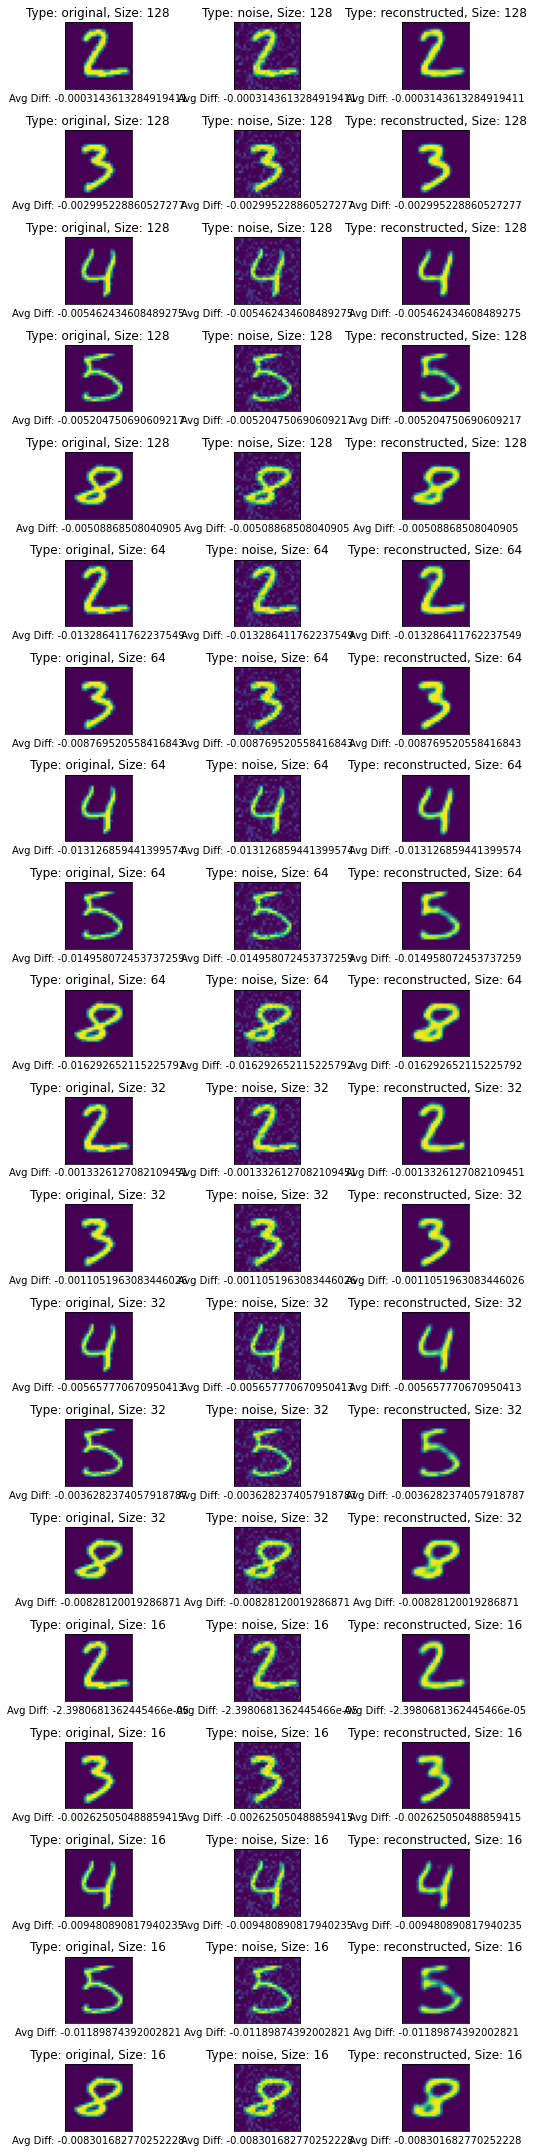

In [150]:
def predict_with_model(img, model):
    val = img[np.newaxis, :, :]
    return model.predict(val)[0,:,:]

# Loop through training results (models, histories of different coding layer sizes)
fig, axes = plt.subplots(nrows=20, ncols=3, figsize=(8,30))
# Loop through results of training (histories, models)
min_diff = 1000000
best_layer_size = -1
for i, result in enumerate(results):
    # Select model
    model = result['model']
    size = result['coding_layer_size']
    for j, image_dict in enumerate(images):
        original = image_dict['original']
        reconstructed = predict_with_model(original, model)
        image_dict['reconstructed'] = reconstructed
        avg_diff = np.mean(original - reconstructed)
        if avg_diff < min_diff:
            min_diff = avg_diff
            best_layer_size = i
        for k, (key, val) in enumerate(image_dict.items()):
            index = (i * 5) + j
            ax = axes[index][k]
            ax.imshow(val)
            ax.set_title(f'Type: {key}, Size: {size}')
            ax.set_xlabel(f'Avg Diff: {avg_diff}')
            ax.set_xticks([])
            ax.set_yticks([])

fig.tight_layout()
print(best_layer_size)
# 128 is the best layer size